<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/02-linear-regression/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# First Name: Платон

# Last Name: Рогожин

## Task 1 (3 points)

Consider the following toy dataset:

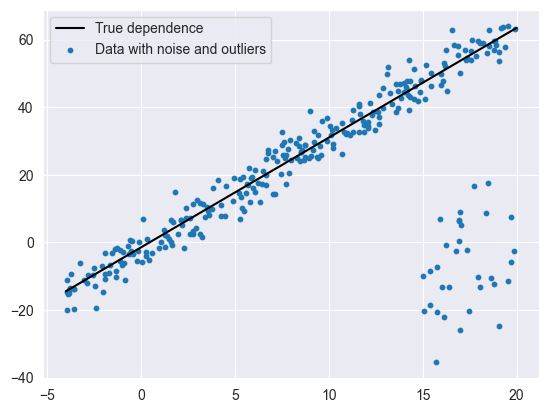

In [2]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

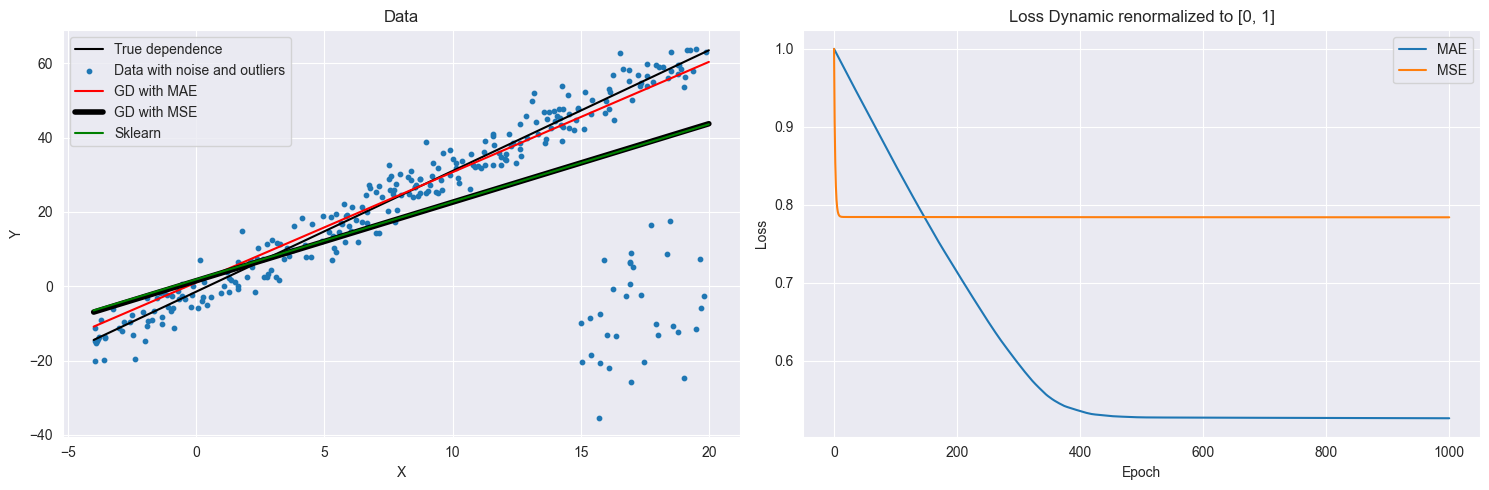

In [95]:
X_new = np.concatenate([X, np.ones(shape=(X.shape[0], 1))], axis=1)

def mae_loss(X, y, w):
    return np.mean(np.abs(X @ w - y))

def mse_loss(X, y, w):
    return np.mean((X @ w - y) ** 2)

w1 = np.ones(X_new.shape[1])
w2 = np.ones(X_new.shape[1])

lr = 0.001
max_epoch = 1000

loss_history1 = np.zeros(max_epoch)
loss_history2 = np.zeros(max_epoch)

for epoch in range(max_epoch):
    gradient1 = ((1./X_new.shape[0]) * np.sign(X_new@w1 - y)) @ X_new
    gradient2 = ((1./X_new.shape[0]) * (2.) * (X_new@w2 - y)) @ X_new
    w1 -= gradient1 * lr
    w2 -= gradient2 * lr
    loss1 = mae_loss(X_new, y, w1)
    loss2 = mse_loss(X_new, y, w2)
    loss_history1[epoch] = loss1
    loss_history2[epoch] = loss2

sk_model = LinearRegression()
sk_model.fit(X, y)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(*limits, 101)
axs[0].plot(x, true_function(x), c='black', label='True dependence')
axs[0].scatter(X, y, s=10, label='Data with noise and outliers')
axs[0].plot(x, w1[0] * x + w1[1], c='r', label='GD with MAE')
axs[0].plot(x, w2[0] * x + w2[1], c='black', label='GD with MSE', linewidth=4)
axs[0].plot(x, sk_model.coef_ * x + sk_model.intercept_, c='g', label='Sklearn')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Data')
axs[0].legend()

axs[1].plot(np.linspace(0, max_epoch, max_epoch), loss_history1/loss_history1[0], label='MAE')
axs[1].plot(np.linspace(0, max_epoch, max_epoch), loss_history2/loss_history2[0], label='MSE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Dynamic renormalized to [0, 1]')
axs[1].legend()
plt.tight_layout()
plt.show()


Явно видно (особенно если нарисовать поверх), что встроенный метод по умолчанию использует MSE.

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [97]:
from sklearn.base import BaseEstimator, RegressorMixin

In [118]:
class LinearRergessionGD(BaseEstimator, RegressorMixin):
    def __init__(self,
                 lr: float=1e-3,
                 max_epoch: int=10,
                 loss_func: str='mse') -> None:
        self.lr = lr
        self.max_epoch = max_epoch
        self.loss_func = loss_func
        self.loss_history = np.zeros(self.max_epoch)

    def fit(self, x, y):
        def calculate_grad_loss_mae(X_new, y, w):
            return ((1./X_new.shape[0]) * np.sign(X_new@w - y)) @ X_new, mae_loss(X_new, y, w)
        def calculate_grad_loss_mse(X_new, y, w):
            return ((1./X_new.shape[0]) * (2.) * (X_new@w - y)) @ X_new, mse_loss(X_new, y, w)

        if self.loss_func == 'mae':
            calculate_grad_loss = calculate_grad_loss_mae
        elif self.loss_func == 'mse':
            calculate_grad_loss = calculate_grad_loss_mse

        X_new = np.concatenate([x, np.ones(shape=(x.shape[0], 1))], axis=1)
        w = np.ones(X_new.shape[1])

        for epoch in range(self.max_epoch):
            gradient, loss = calculate_grad_loss(X_new, y, w)
            w -= gradient * self.lr
            self.loss_history[epoch] = loss

        self.w = w
        self.coef_ = self.w[0]
        self.intercept_ = self.w[1]
        return self

    def predict(self, x):
        return x @ self.w
    
    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

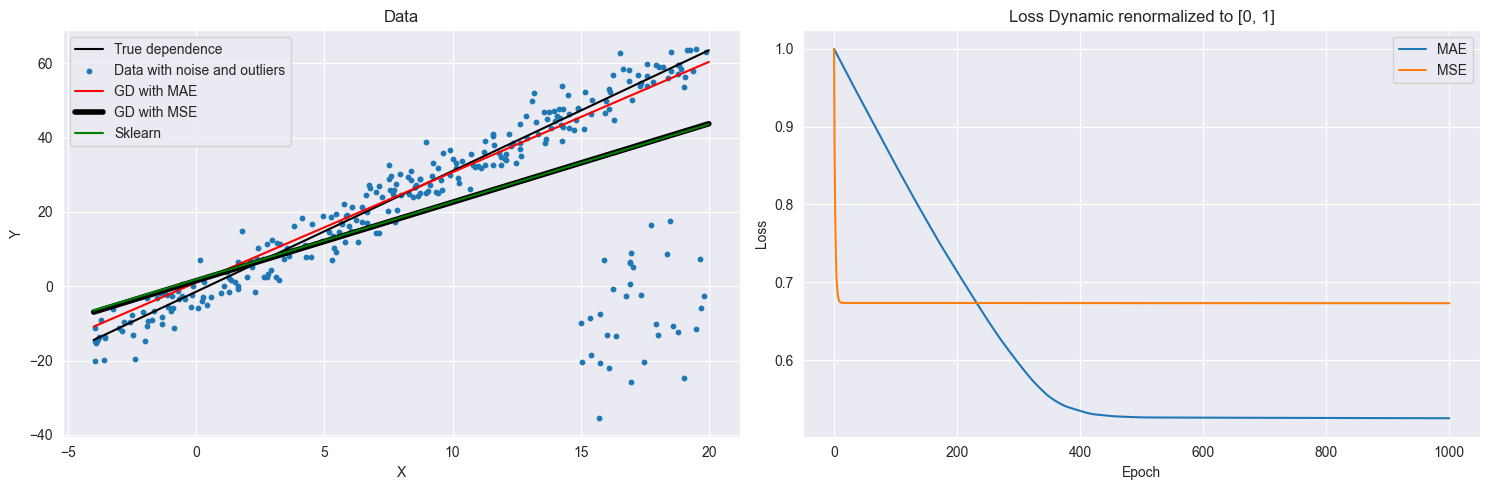

In [119]:
model1 = LinearRergessionGD(lr, max_epoch, 'mae')
model2 = LinearRergessionGD(lr, max_epoch, 'mse')
model1.fit(X, y)
model2.fit(X, y)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(*limits, 101)
axs[0].plot(x, true_function(x), c='black', label='True dependence')
axs[0].scatter(X, y, s=10, label='Data with noise and outliers')
axs[0].plot(x, model1.coef_ * x + model1.intercept_, c='r', label='GD with MAE')
axs[0].plot(x, model2.coef_ * x + model2.intercept_, c='black', label='GD with MSE', linewidth=4)
axs[0].plot(x, sk_model.coef_ * x + sk_model.intercept_, c='g', label='Sklearn')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title('Data')
axs[0].legend()

axs[1].plot(np.linspace(0, max_epoch, max_epoch), model1.loss_history/model1.loss_history[0], label='MAE')
axs[1].plot(np.linspace(0, max_epoch, max_epoch), model2.loss_history/model2.loss_history[0], label='MSE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Dynamic renormalized to [0, 1]')
axs[1].legend()
plt.tight_layout()
plt.show()

Про стохастичность в задании, кроме как одной буквы в названии класса ничего не упоминается, поэтому имплементировать не стал.

По заданию вообще не понимаю что может отличаться в выполнении одного и того же алгоритма, загнан он в класс или нет, не считая моментов с рандомом, которых здесь нет. Поэтому требуемый в задании комментарий: абсолютно одинаковые, как и ожидалось.

Если я что-то сделал не так, потому что в задании об этом ничего не написано, ну извините.

